In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"

sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from DLS.postprocess import *
from code_comparison.solps_pp import *

from DLScommonTools import *
from Morph import *
from Postprocess import *
from copy import deepcopy

%matplotlib inline
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2


# Read balance file

In [4]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=0, resolution = 10000)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [2]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

# Setup and run DLS

In [3]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

In [9]:
cvar = "density"
design = "SPR45"
side = "ol"

store = dict()

    
d = eqb["SPR45"][side].copy()
constants = constants_default.copy() # Set settings to default
radios = radios_default.copy() # Set settings to default
SparRange = np.linspace(0, d["S"][d["Xpoint"]], 20) # Solve at these parallel positions

if "i" in side:
    constants["qpllu0"] = 1.5e9
elif "o" in side:
    constants["qpllu0"] = 2e9

results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)

store = copy.deepcopy(results)

Solving...0...740...1282...1762...2194...2559...2848...3069...3236...3364...3462...3538...3597...3643...3677...3702...3722...3739...

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3755...3769...Complete in 135.3 seconds


In [231]:
file_write(store, "2024-01-23 - New inner divertor - 100 points.pkl")

In [112]:
%matplotlib inline
plt.close("all")

In [82]:
self = DLSoutput(eqb["SPR45"]["ol"], store.copy())


In [8]:
store

{}

In [31]:
df = get_front_widths(p = eqb["SPR45"]["ol"], s = store)
df

,Spol,Spol_front_end,Spol_front_start,Spol_front_width,Spol_5eV,Spar,Spar_front_end,Spar_front_start,Spar_front_width,Spar_5eV,cvar,crel,Btot,Btot_eff,Tu
0,0.000000,0.001140,0.157319,0.156179,0.0,0.000000,0.002811,21.609083,21.606271,0.0,7.101701e+19,1.000000,2.172194,2.936393,251.352672
1,0.843650,0.844790,1.032920,0.188129,0.0,2.745443,2.750049,25.319787,22.569738,0.0,7.675707e+19,1.080826,2.393211,3.115163,248.254008
2,1.461618,1.462758,1.703321,0.240563,0.0,5.490069,5.495516,28.931688,23.436172,0.0,8.301689e+19,1.168972,2.667782,3.309523,244.893899
3,2.008858,2.009998,2.288161,0.278164,0.0,8.236908,8.242910,32.211447,23.968537,0.0,8.900624e+19,1.253309,2.940034,3.491902,241.250685
4,2.501340,2.502480,2.892355,0.389875,0.0,10.984138,10.990968,35.319747,24.328779,0.0,9.470024e+19,1.333487,3.205942,3.661701,237.398736
5,2.917435,2.918575,3.680080,0.761505,0.0,13.727032,13.735435,38.276727,24.541291,0.0,1.000371e+20,1.408636,3.460156,3.817019,233.422264
6,3.246891,3.248031,4.815305,1.567274,0.0,16.474763,16.485646,41.183745,24.698099,0.0,1.049767e+20,1.478191,3.694286,3.954347,229.358047
7,3.498829,3.499969,6.066749,2.566780,0.0,19.224002,19.238343,43.896577,24.658234,0.0,1.097247e+20,1.545048,3.899248,4.070284,225.384121
8,3.689200,3.690341,6.969525,3.279184,0.0,21.960868,21.979727,46.764036,24.784309,0.0,1.142091e+20,1.608194,4.070541,4.163612,221.482039
9,3.835133,3.836272,7.619586,3.783314,0.0,24.711936,24.736577,49.636185,24.899608,0.0,1.184454e+20,1.667845,4.212120,4.237070,217.414525


In [28]:
Rint*1e-9

1.5410810694965391

2.9363933664277098


Text(0.5, 1.0, 'B enhancement')

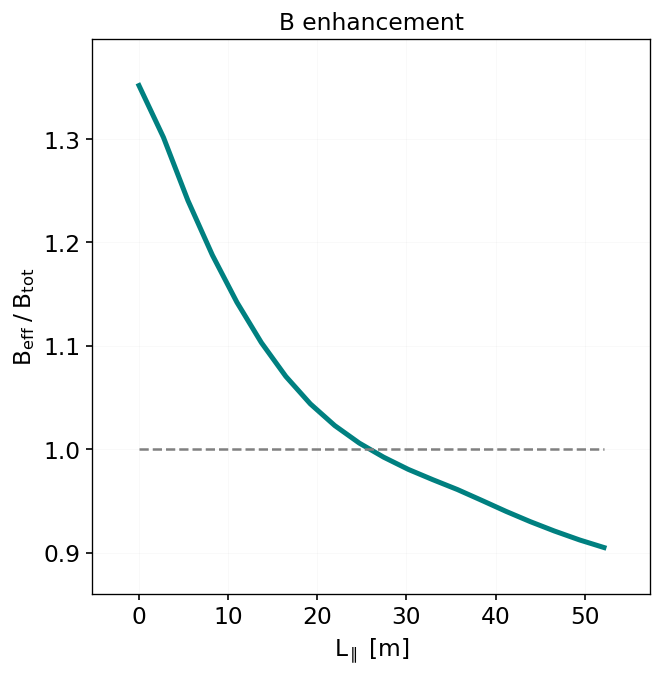

In [49]:
p = eqb["SPR45"]["ol"]
s = store

R = s["Rprofiles"][0]
B = p["Btot"]

Rint = sp.integrate.trapezoid(y = R, x = p["S"])
Beff = sp.integrate.trapezoid(y = R*B, x = p["S"]) / Rint
print(Beff)

fig, ax = plt.subplots(figsize = (6,6))

ax.plot(df["Spar"], df["Btot_eff"] / df["Btot"])
ax.set_xlabel("$L_{\parallel}$ [m]")
ax.set_ylabel("$B_{eff} \ /\  B_{tot}$")
ax.hlines(1, 0, df["Spar"].iloc[-1], color = "grey", linestyle = "--", lw = 1.5)
ax.set_title("B enhancement")
# ax.set_ylim(0,0.1e9)

2.9363933664277098


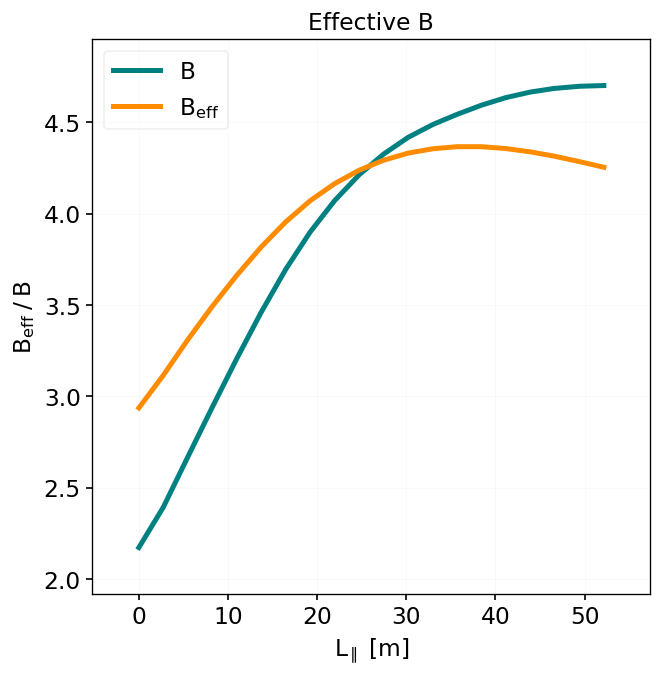

In [58]:
p = eqb["SPR45"]["ol"]
s = store

R = s["Rprofiles"][0]
B = p["Btot"]

Rint = sp.integrate.trapezoid(y = R, x = p["S"])
Beff = sp.integrate.trapezoid(y = R*B, x = p["S"]) / Rint
print(Beff)

fig, ax = plt.subplots(figsize = (6,6))

ax.plot(df["Spar"], df["Btot"], label = "$B$")
ax.plot(df["Spar"], df["Btot_eff"], label = "$B_{eff}$")
ax.set_xlabel("$L_{\parallel}$ [m]")
ax.set_ylabel("$B_{eff} \ /\  B$")
# ax.hlines(1, 0, df["Spar"].iloc[-1], color = "grey", linestyle = "--", lw = 1.5)
ax.set_title("Effective B")
ax.legend()
# ax.set_ylim(0,0.1e9)

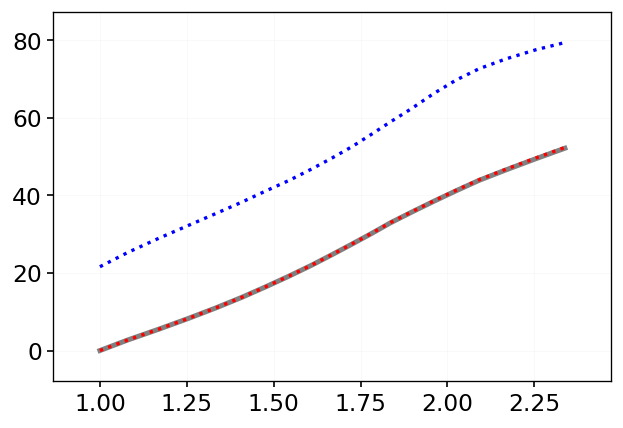

In [149]:
fig, ax = plt.subplots(figsize = (6,4))

ax.plot(df["crel"], df["Spar"], c = "grey")
ax.plot(df["crel"], df["Spar_front_end"], ls = ":", lw = 2, c = "red")
ax.plot(df["crel"], df["Spar_front_start"], ls = ":", lw = 2, c = "blue")

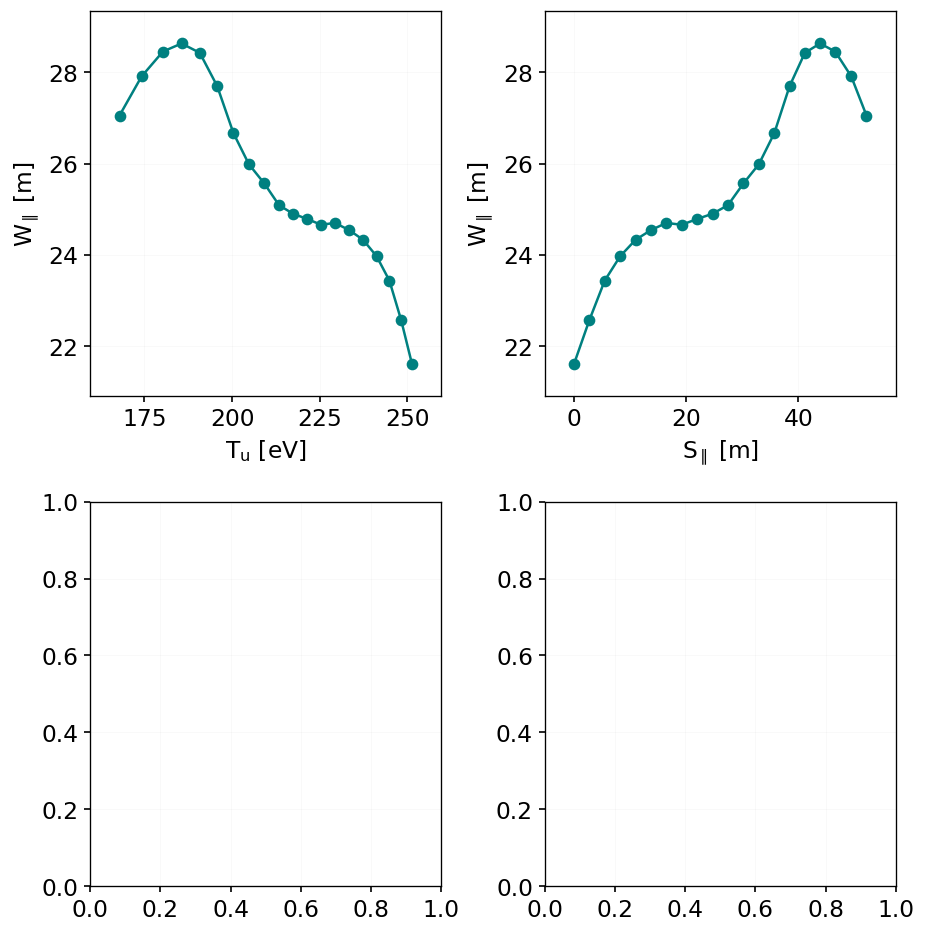

In [136]:
fig, axes = plt.subplots(2,2, figsize = (8,8))
# ax.plot(df["Spar"], df["Spar_front_width"])

ax = axes[0,0]
ax.plot(df["Tu"], df["Spar_front_width"], marker = "o", lw = 1.5)
ax.set_xlabel("$T_{u}$ [eV]")
ax.set_ylabel(r"$W_{\parallel}$ [m]")

ax = axes[0,1]
ax.plot(df["Spar"], df["Spar_front_width"], marker = "o", lw = 1.5)
ax.set_xlabel("$S_{\parallel}$ [m]")
ax.set_ylabel(r"$W_{\parallel}$ [m]")


fig.tight_layout()

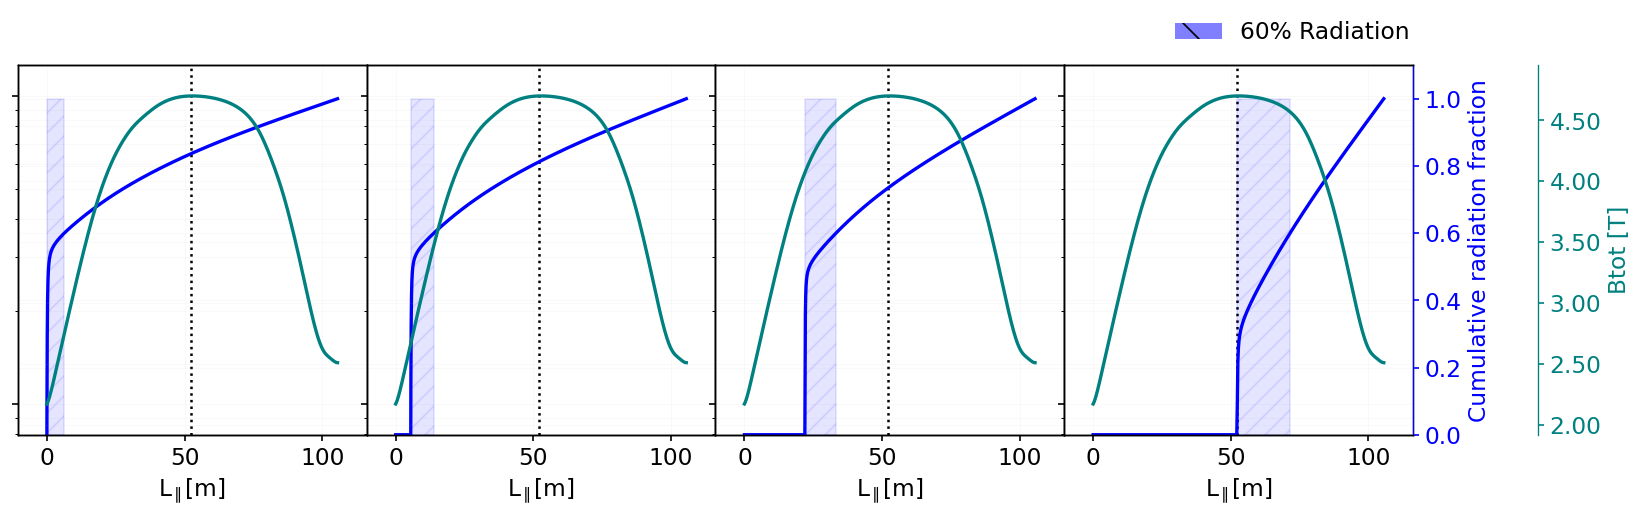

In [48]:
# for mode in ["temp", "qpar"]:
for mode in ["Btot"]:
    plot_profile_histories(eqb["SPR45"]["ol"], store, list_idx = [0,2,8,19], mode = mode, axis = "parallel", rad_threshold = 0.6)

In [251]:
i

3